## Chapter 4. A look at 3D reconstructions

In this section we will reconstruct a molecule from a three-dimensional data set. First, construct a uniformly spaced three-dimensional grid in Fourier space with the commands **xyzgrid**,

In [1]:
%%capture
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)

# add path to the Modules
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..', 'src'))

from Reconstruction import *

In [2]:
# Initialize the notebook for creating 3D plots. Only need to call once.
# Two options: x3d or png
# x3d: allows interactive operation (e.g. 3D rotation)
# png: static (not easy to make it work)
# See http://docs.enthought.com/mayavi/mayavi/tips.html for more details.
mlab.init_notebook('x3d', local=False)

Notebook initialized with x3d backend.


In [3]:
cutoff = 2
step = 1./8
H, K, L = xyzgrid(cutoff, step)

If you like, you can view the grid that you just created

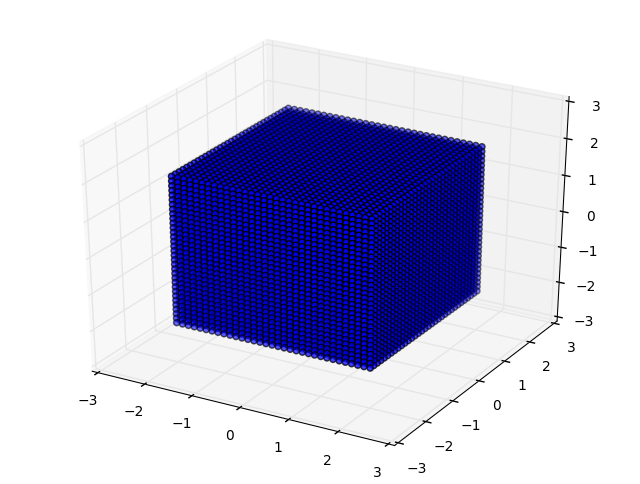

In [4]:
ax = plt.figure().gca(projection='3d')
ax.scatter(H, K, L)
plt.show()

Then calculate the molecular transform of caffeine on the grid points with **moltrans**.

In [5]:
# Read the pdb file for caffeine molecule.
caf = Molecule('caffeine.pdb')

In [6]:
F = moltrans(caf, H,K,L)

You should now have a three-dimensional sample set of the molecular transform. You can use the **slice** function to get an idea of what the data look like. The commands

In [7]:
slice(H,K,L,np.log(abs(F)**2),0,0,0)

displays the absolute square of the data on three planes through the origin. The Fourier transform of each of these planes correspond to a projection image of the molecule's electron density; the horizontal plane is the one that you have been using for most of the tasks in this tutorial.

Next, compute the three-dimensional electron density by Fourier transforming **F**,

In [8]:
rho = fft.fftshift(abs(fft.ifftn(F, [2**6, 2**6, 2**6])))

and calculate correctly scaled real-space coordinates with the lines

In [9]:
Nx, Ny, Nz = rho.shape
x = 1./(Nx*step) * (np.linspace(0, Nx-1, Nx) - np.floor(Nx/2.))
y = 1./(Ny*step) * (np.linspace(0, Ny-1, Ny) - np.floor(Ny/2.))
z = 1./(Nz*step) * (np.linspace(0, Nz-1, Nz) - np.floor(Nz/2.))
[X, Y, Z] = np.meshgrid(x, y, z)

Take a look at resulting electron density with **slice**,

In [10]:
slice(X,Y,Z,rho,0,0,0)

Slice planes are one way of visualizing a volume of data; isosurfaces are another. An isosurface is a three-dimensional analogue to a contour plot -- it is a surface that connects points in the volume that have a given value. Below you will plot isosurfaces of the electron density, but first you should put it on an absolute scale,

In [11]:
rhoScale = step**3 * np.prod(rho.shape)
rho = rho * rhoScale

You don't need to understand this scale factor (it stems from the of use the discrete Fourier transform rather than the continuous one), only that it ensures that the electron density is given in units of electrons/$\overset{\circ}{\text{A}}$$^3$. To draw an isosurface at a given level of electron density, use the command **isosurface(rho, values)**, where the argument **values** can be either a number or a list of number (although in this case the isosurfaces might overlap with each other).

In [12]:
isosurface(rho, 5)

Choose a different value:

In [13]:
isosurface(rho, 3)

At levels below 3 electrons/$\overset{\circ}{\text{A}}$$^3$, you will see that side lobes appear around the atoms. These are due to the sinc function the transform of the rectangular cut-off that you used when calculating the molecular transform. To remove the side lobes, we will change the rectangular window that effects the cut-off into a Gaussian window with approximately the same width (a Gaussian with standard deviation of 1 $\overset{\circ}{\text{A}}$$^{-1}$ gets it about right). You can use the following code to generate the Gaussian and multiply it with the molecular transform:

In [14]:
# Compute Gaussian window
sigma = 1
G = np.exp(-(H**2 + K**2 + L**2)/(2*sigma**2))
# Multiply the molecular transform with the window.
F = F*G

Now inverse transform **F** again (don't forget to multiply by the scaling factor for the density), and view the result with **isosurface**.

In [15]:
rho = fft.fftshift(abs(fft.ifftn(F, [2**6, 2**6, 2**6]))) * rhoScale

In [16]:
isosurface(rho, 5)

Choose a different value:

In [17]:
isosurface(rho, 3)

As you see, the result is considerably smoother. <span style="color:blue">Why is this?</span> The key is the Fourier transform of the window function, which in the case of the Gaussian is given by

$$
\mathcal{F}^{-1} \left \{ \exp \left( -\frac{k^2}{2\sigma^2} \right) \right \} = \sigma \sqrt{2\pi} \exp (-2\pi x^2 \sigma^2)
$$

i.e. another Gaussian, but with standard deviation $1/(2\pi\sigma)$. If you run the function **wincomp** you will see a one-dimensional comparison of the two windows and their transforms. The real-space Gaussian is slightly wider than the main lobe of the corresponding sinc function, but on the other hand it lacks the side-lobes.

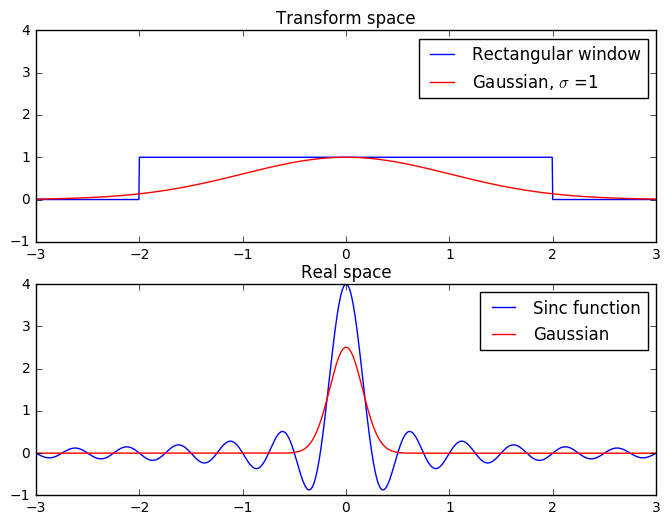

In [18]:
wincomp()

Finally calculate the sum of the electron density.

In [19]:
1./rhoScale * sum(sum(sum(rho)))

92.194418817964674

In [20]:
F[16,16,16]

(91.970803999999987+0j)

The scale factor is there in order for the sum to be computed correctly. <span style="color:blue">What physical quantity does the sum represent?</span> The value that the molecular transform takes at the origin represents the same quantity (the origin is at the midpoint of the matrix, **F(16,16,16)** with the settings that I've given in tutorial). <span style="color:blue">Can you explain why?</span> Hint: take the integral for the Fourier transform of the density, set $k$ to zero and simplify.

$$
F(0) = \int \rho (\vec{r}) \text{d}^3 r
$$

In a crystal, the positions of the atoms may vary slightly between different unit cells. To an imaging system, this looks like the atom has been smeared out (convoluted, more precisely) by a distribution which, to first approximation, is Gaussian. Therefore, by the convolution theorem, the crystalline diffraction pattern (the Bragg peaks) decreases in intensity with the distance from the origin as if it had been multiplied by a Gaussian. This is called the Debye-Waller factor or the temperature factor.